# Capstone Project - The Battle of Neighborhoods

### Analyze restaurants in New York City for potential owners

Download the dependencies

In [1]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

!conda install -c conda-forge geopy 
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

!conda install -c conda-forge folium=0.5.0
import folium # map rendering library

Solving environment: done

## Package Plan ##

  environment location: /opt/conda/envs/Python36

  added / updated specs: 
    - geopy


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    python_abi-3.6             |          1_cp36m           4 KB  conda-forge
    geopy-2.0.0                |     pyh9f0ad1d_0          63 KB  conda-forge
    certifi-2020.6.20          |   py36h9f0ad1d_0         151 KB  conda-forge
    ca-certificates-2020.6.20  |       hecda079_0         145 KB  conda-forge
    geographiclib-1.50         |             py_0          34 KB  conda-forge
    openssl-1.1.1g             |       h516909a_0         2.1 MB  conda-forge
    ------------------------------------------------------------
                                           Total:         2.5 MB

The following NEW packages will be INSTALLED:

    geographiclib:   1.50-py_0          conda-forge
    geopy:           

Get and define the data

In [2]:
!wget -q -O 'newyork_data.json' https://cocl.us/new_york_dataset
with open('newyork_data.json') as json_data:
    temp_data = json.load(json_data)
source_data = temp_data['features']

# Define the dataframe columns
column_names = ['Borough', 'Neighborhood', 'Latitude', 'Longitude'] 
# Instantiate the dataframe
newyork_data = pd.DataFrame(columns=column_names)

for data in source_data:
    borough = data['properties']['borough'] 
    neighborhood_name = data['properties']['name']        
    neighborhood_latlon = data['geometry']['coordinates']
    neighborhood_lat = neighborhood_latlon[1]
    neighborhood_lon = neighborhood_latlon[0]
    
    newyork_data = newyork_data.append({'Borough': borough,
                                          'Neighborhood': neighborhood_name,
                                          'Latitude': neighborhood_lat,
                                          'Longitude': neighborhood_lon}, ignore_index=True)

# Check output
newyork_data.head()    

,Borough,Neighborhood,Latitude,Longitude
0,Bronx,Wakefield,40.894705,-73.847201
1,Bronx,Co-op City,40.874294,-73.829939
2,Bronx,Eastchester,40.887556,-73.827806
3,Bronx,Fieldston,40.895437,-73.905643
4,Bronx,Riverdale,40.890834,-73.912585


Visualise neighborhoods in NYC by borough

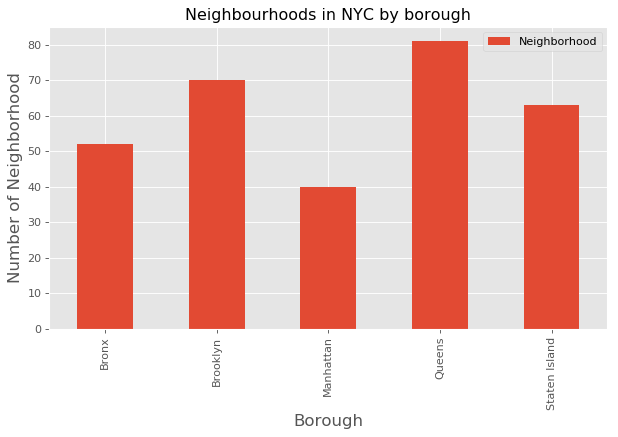

In [4]:
from matplotlib import pyplot as plt
plt.style.use('ggplot')

plt.figure(figsize=(9,5), dpi = 80)
plt.title('Neighbourhoods in NYC by borough')
plt.xlabel('Borough', fontsize = 15)
plt.ylabel('Number of Neighborhood', fontsize=15)
newyork_data.groupby('Borough')['Neighborhood'].count().plot(kind='bar')

plt.legend()
plt.show()

Let's take a closer look at 'Queens' as it has more than 80 neighborhoods

In [5]:
# function to intract with FourSquare API and get top 100 venues within a radius of 1000 metres 
def get_venues(lat,lng):    
    radius=1000
    LIMIT=100
    CLIENT_ID = 'KRPQRX5MZF3U0KYGNULSSKE3XPMDE1RZXCW01Y0S1B4LHAY5' 
    CLIENT_SECRET = 'JCTJJ3LNRSQZT1NYVVCJO34DWHVL44FNNL43FFCWF5UNCBPA' 
    VERSION = '20200623' 
    
    #url to fetch data from foursquare api
    url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
    
    # get all the data
    results = requests.get(url).json()
    venue_data=results["response"]['groups'][0]['items']
    venue_details=[]
    for row in venue_data:
        try:
            venue_id=row['venue']['id']
            venue_name=row['venue']['name']
            venue_category=row['venue']['categories'][0]['name']
            venue_details.append([venue_id,venue_name,venue_category])
        except KeyError:
            pass
        
    column_names=['ID','Name','Category']
    df = pd.DataFrame(venue_details,columns=column_names)
    return df

In [6]:
# define dataframe for Queens
queens_data = newyork_data[newyork_data['Borough'] == 'Queens'].reset_index(drop=True)

# get restaurant detail from FourSquare API
column_names=['Neighborhood', 'ID', 'Name', 'Category']
queens_restaurant=pd.DataFrame(columns=column_names)

count=1
for row in queens_data.values.tolist():
    Borough, Neighborhood, Latitude, Longitude=row
    restaurant_detail = get_venues(Latitude,Longitude)
    
    for detail in restaurant_detail.values.tolist():
        id, name , category = detail
        queens_restaurant = queens_restaurant.append({'Neighborhood': Neighborhood,
                                                      'ID': id,
                                                      'Name' : name,
                                                      'Category' : category
                                                     }, ignore_index=True)

    count+=1
 
# check output
queens_restaurant.head()

,Neighborhood,ID,Name,Category
0,Astoria,4bdf502a89ca76b062b75d5e,Favela Grill,Brazilian Restaurant
1,Astoria,4a9c0105f964a520b03520e3,Titan Foods Inc.,Gourmet Shop
2,Astoria,4c94d26d58d4b60c40fc2b29,CrossFit Queens,Gym
3,Astoria,4d7ce85486cfa14365a2d2a0,Simply Fit Astoria,Gym
4,Astoria,4ba58abaf964a520d01039e3,Al-sham Sweets and Pastries,Middle Eastern Restaurant


In [7]:
queens_restaurant.shape

(5226, 4)

Visualise top 20 restaurants in Queens by Category

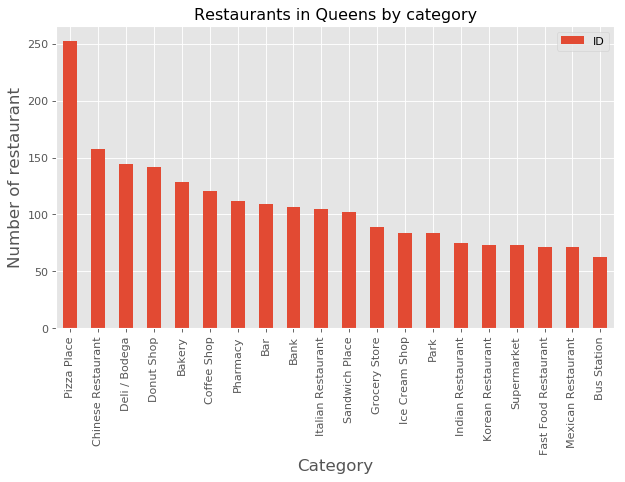

In [8]:
from matplotlib import pyplot as plt
plt.style.use('ggplot')

plt.figure(figsize=(9,5), dpi = 80)
plt.title('Restaurants in Queens by category')
plt.xlabel('Category', fontsize = 15)
plt.ylabel('Number of restaurant', fontsize=15)
queens_restaurant.groupby('Category')['ID'].count().nlargest(20).plot(kind='bar')

plt.legend()
plt.show()

Pizza Place is the most common type of restaurant in Queens

Let's check the venue details of Pizza Place in Queens

In [42]:
def get_venue_details(venue_id):
        
    CLIENT_ID = 'KRPQRX5MZF3U0KYGNULSSKE3XPMDE1RZXCW01Y0S1B4LHAY5' 
    CLIENT_SECRET = 'JCTJJ3LNRSQZT1NYVVCJO34DWHVL44FNNL43FFCWF5UNCBPA' 
    VERSION = '20200623' 
    
    #url to fetch data from foursquare api
    url = 'https://api.foursquare.com/v2/venues/{}?&client_id={}&client_secret={}&v={}'.format(
            venue_id,
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION)
    
    # get all the data
    results = requests.get(url).json()
    venue_data=results['response']['venue']
    venue_details=[]
    try:
        venue_id=venue_data['id']
        venue_name=venue_data['name']
        venue_likes=venue_data['likes']['count']
        venue_rating=venue_data['rating']
        venue_tips=venue_data['tips']['count']
        venue_details.append([venue_id,venue_name,venue_likes,venue_rating,venue_tips])
    except KeyError:
        pass
        
    column_names=['ID','Name','Likes','Rating','Tips']
    df = pd.DataFrame(venue_details,columns=column_names)
    return df

In [43]:
# define dataframe for Pizza Place in Queens
pizza_queens_restaurant = queens_restaurant[queens_restaurant['Category'] == 'Pizza Place'].reset_index(drop=True)
pizza_queens_restaurant.drop('Category', axis=1, inplace=True)
pizza_queens_restaurant.head()

,Neighborhood,ID,Name
0,Astoria,4df92f12e4cd56a64982415f,Basil Brick Oven Pizza
1,Astoria,5b285f19d69ed0002c19b0e0,Macoletta
2,Astoria,51831cbf498e954462363bd3,Milkflower
3,Astoria,5541a608498ecffd52f91dfc,Astoria Pizza
4,Astoria,4a54014df964a520f0b21fe3,Rizzo's Fine Pizza


In [44]:
# get venue detail from FourSquare API
for row in pizza_queens_restaurant.values.tolist():
    Neighborhood,ID,Name=row

column_names=['Neighborhood','ID','Name','Likes','Rating','Tips']
pizza_queens_rating = pd.DataFrame(columns=column_names)
count=1

for row in pizza_queens_restaurant.values.tolist():
    Neighborhood,ID,Name=row
    try:
        venue_details=get_venue_details(ID)
        print(venue_details)
        id,name,likes,rating,tips=venue_details.values.tolist()[0]
    except (IndexError, KeyError) as e:
        # Assign zero value for resturants which may have been newly opened or does not exist 
        id,name,likes,rating,tips=[0]*5
    pizza_queens_rating = pizza_queens_rating.append({'Neighborhood': Neighborhood,                                                 
                                                'ID': id,
                                                'Name' : name,
                                                'Likes' : likes,
                                                'Rating' : rating,
                                                'Tips' : tips
                                               }, ignore_index=True)
    count+=1

                         ID                    Name  Likes  Rating  Tips
0  4df92f12e4cd56a64982415f  Basil Brick Oven Pizza     93     8.7    51
                         ID       Name  Likes  Rating  Tips
0  5b285f19d69ed0002c19b0e0  Macoletta     15     8.7     7
                         ID        Name  Likes  Rating  Tips
0  51831cbf498e954462363bd3  Milkflower    421     9.4   123
                         ID           Name  Likes  Rating  Tips
0  5541a608498ecffd52f91dfc  Astoria Pizza      6     7.8     3
                         ID                Name  Likes  Rating  Tips
0  4a54014df964a520f0b21fe3  Rizzo's Fine Pizza     56     8.0    41
                         ID         Name  Likes  Rating  Tips
0  4b019141f964a5207e4322e3  Pizza Boy 2     22     8.3    12
                         ID                         Name  Likes  Rating  Tips
0  4b76ec1cf964a520cf6a2ee3  Woodside Pizza & Restaurant     11     7.2     9
                         ID                             Name  Like

In [45]:
pizza_queens_rating.shape

(253, 6)

In [46]:
pizza_queens_rating.head()

,Neighborhood,ID,Name,Likes,Rating,Tips
0,Astoria,4df92f12e4cd56a64982415f,Basil Brick Oven Pizza,93,8.7,51
1,Astoria,5b285f19d69ed0002c19b0e0,Macoletta,15,8.7,7
2,Astoria,51831cbf498e954462363bd3,Milkflower,421,9.4,123
3,Astoria,5541a608498ecffd52f91dfc,Astoria Pizza,6,7.8,3
4,Astoria,4a54014df964a520f0b21fe3,Rizzo's Fine Pizza,56,8.0,41


Check average Rating by neighborhood

In [113]:
avg_rating_stats=pizza_queens_rating
avg_rating_stats[(avg_rating_stats != 0).all(1)]
avg_rating_stats=avg_rating_stats.groupby('Neighborhood',as_index=False).mean()[['Neighborhood','Rating']]
avg_rating_stats.columns=['Neighborhood','Average Rating']
avg_rating_stats.sort_values(['Average Rating'],ascending=False).head(10)

,Neighborhood,Average Rating
19,Elmhurst,8.750000
22,Flushing,8.700000
1,Astoria,8.520000
23,Forest Hills,8.400000
34,Jackson Heights,8.075000
44,Long Island City,8.066667
70,Sunnyside,7.983333
38,Kew Gardens,7.940000
75,Woodside,7.750000
32,Howard Beach,5.700000


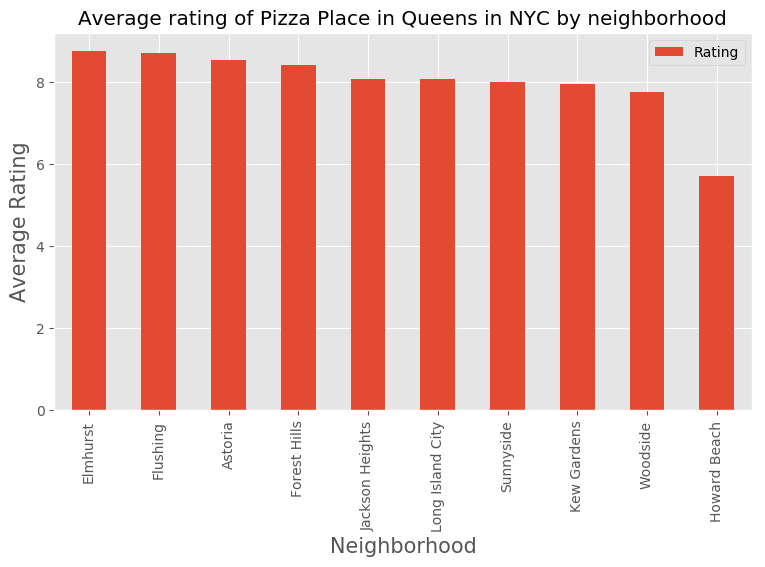

In [121]:
plt.figure(figsize=(9,5), dpi = 100)
plt.title('Average rating of Pizza Place in Queens in NYC by neighborhood')
plt.xlabel('Neighborhood', fontsize = 15)
plt.ylabel('Average Rating', fontsize = 15)
avg_rating_stats['Average Rating'].nlargest(10).plot(kind='bar')

plt.legend()
plt.show()

Check total Likes by neighborhood

In [95]:
tot_likes_stats=pizza_queens_rating
tot_likes_stats[(tot_likes_stats != 0).all(1)]
tot_likes_stats=tot_likes_stats.groupby(['Neighborhood']).agg({'Likes': "sum"})
tot_likes_stats.columns=['Total Likes']
tot_likes_stats.sort_values(['Total Likes'],ascending=False).head(10)


,Total Likes
Neighborhood,
Astoria,591
Howard Beach,324
Kew Gardens,310
Forest Hills,232
Flushing,163
Sunnyside,161
East Elmhurst,121
Elmhurst,107
Long Island City,101


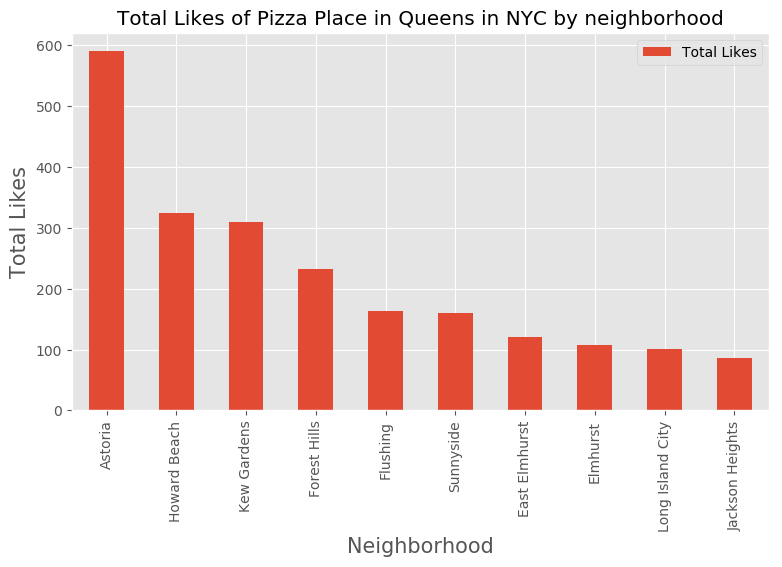

In [115]:
plt.figure(figsize=(9,5), dpi = 100)
plt.title('Total Likes of Pizza Place in Queens in NYC by neighborhood')
plt.xlabel('Neighborhood', fontsize = 15)
plt.ylabel('Total Likes', fontsize = 15)
tot_likes_stats['Total Likes'].nlargest(10).plot(kind='bar')

plt.legend()
plt.show()

Check total Tips by neighborhood

In [96]:
tot_tips_stats=pizza_queens_rating
tot_tips_stats[(tot_tips_stats != 0).all(1)]
tot_tips_stats=tot_tips_stats.groupby(['Neighborhood']).agg({'Tips': "sum"})
tot_tips_stats.columns=['Total Tips']
tot_tips_stats.sort_values(['Total Tips'],ascending=False).head(10)

,Total Tips
Neighborhood,
Astoria,225
Kew Gardens,170
Howard Beach,131
Forest Hills,116
East Elmhurst,104
Flushing,96
Sunnyside,87
Jackson Heights,61
Elmhurst,48


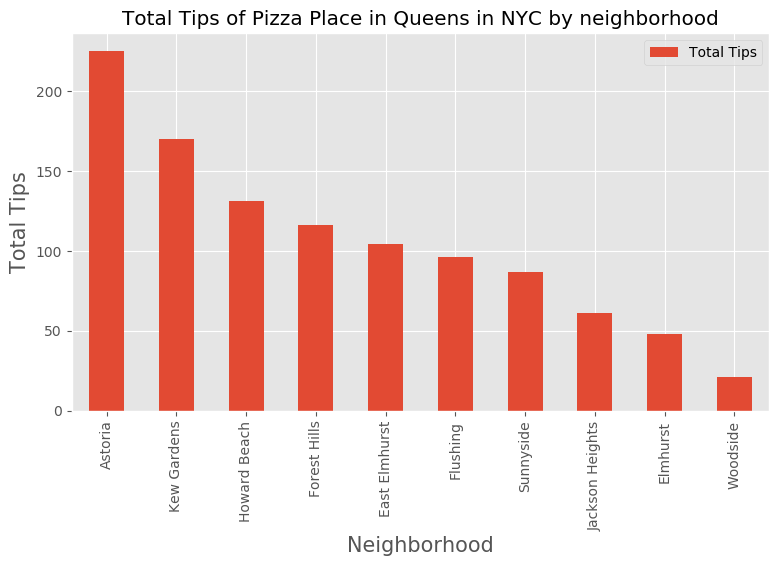

In [116]:
plt.figure(figsize=(9,5), dpi = 100)
plt.title('Total Tips of Pizza Place in Queens in NYC by neighborhood')
plt.xlabel('Neighborhood', fontsize = 15)
plt.ylabel('Total Tips', fontsize = 15)
tot_tips_stats['Total Tips'].nlargest(10).plot(kind='bar')

plt.legend()
plt.show()